# Squid Ink VWAP Analysis - Round 2

This notebook analyzes the VWAP (Volume-Weighted Average Price) for Squid Ink in Round 2.

In [1]:
# Import necessary libraries
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add parent directories to path for imports
sys.path.append(os.path.abspath('../../..'))
sys.path.append(os.path.abspath('../../../..'))

# Try to set better plot styling
try:
    sns.set(style="whitegrid")
    print("Using Seaborn for plot styling")
except Exception as e:
    print(f"Seaborn styling not available: {e}")
    
# Configure plots to be larger and more readable
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

Using Seaborn for plot styling


## 1. Load Data

First, let's load the Squid_Ink price data for Round 2.

In [3]:
# Try to import the backtester package first
try:
    from backtester import get_price_data
    print("Successfully imported backtester.get_price_data")
    
    # Load data using backtester
    print("Loading price data using backtester...")
    prices = get_price_data('SQUID_INK', 2)
    print(f"Successfully loaded price data with {len(prices)} rows")
    
except ImportError:
    print("Could not import backtester. Trying alternative method...")
    
    # Try to import from util_minimal in data_utils
    try:
        sys.path.append(os.path.abspath('../../data_utils'))
        import util_minimal
        print("Successfully imported util_minimal")
        
        # Load data using util_minimal
        print("Loading price data using util_minimal...")
        all_prices = util_minimal.load_all_price_data(2)
        prices = all_prices[all_prices['product'] == 'SQUID_INK']
        print(f"Successfully loaded price data with {len(prices)} rows")
        
    except ImportError:
        print("Could not import util_minimal. Trying direct CSV loading...")
        
        # Define a function to load price data from CSV files
        def load_price_data(round_num):
            # Path to data directory
            data_path = '../../../Prosperity 3 Data'
            
            # List all CSV files for the round
            import glob
            file_pattern = os.path.join(data_path, f'Round {round_num}/prices_round_{round_num}_day_*.csv')
            files = glob.glob(file_pattern)
            
            if not files:
                print(f"No files found matching pattern: {file_pattern}")
                return pd.DataFrame()
            
            # Load and concatenate all files
            dfs = []
            for file in files:
                print(f"Loading {file}...")
                df = pd.read_csv(file, sep=';')
                dfs.append(df)
            
            # Concatenate all dataframes
            all_data = pd.concat(dfs, ignore_index=True)
            
            # Filter for SQUID_INK
            squid_data = all_data[all_data['product'] == 'SQUID_INK']
            
            return squid_data
        
        # Load data using direct CSV loading
        print("Loading price data from CSV files...")
        prices = load_price_data(2)
        print(f"Successfully loaded price data with {len(prices)} rows")

Could not import backtester. Trying alternative method...
Could not import util_minimal. Trying direct CSV loading...
Loading price data from CSV files...
Loading ../../../Prosperity 3 Data\Round 2\prices_round_2_day_-1.csv...
Loading ../../../Prosperity 3 Data\Round 2\prices_round_2_day_0.csv...
Loading ../../../Prosperity 3 Data\Round 2\prices_round_2_day_1.csv...
Successfully loaded price data with 30000 rows


## 2. Examine the Data

Let's take a look at the structure of the data.

In [4]:
# Display the first few rows of the data
print("First few rows of the data:")
prices.head()

First few rows of the data:


,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
2,-1,0,SQUID_INK,2005,1,2002.0,31.0,NaN,NaN,2006,31,NaN,NaN,NaN,NaN,2005.5,0.0
15,-1,100,SQUID_INK,2004,24,NaN,NaN,NaN,NaN,2007,24,NaN,NaN,NaN,NaN,2005.5,0.0
21,-1,200,SQUID_INK,2003,22,NaN,NaN,NaN,NaN,2006,20,NaN,NaN,NaN,NaN,2004.5,0.0
25,-1,300,SQUID_INK,2003,31,NaN,NaN,NaN,NaN,2006,31,NaN,NaN,NaN,NaN,2004.5,0.0
34,-1,400,SQUID_INK,2004,27,NaN,NaN,NaN,NaN,2007,27,NaN,NaN,NaN,NaN,2005.5,0.0


In [5]:
# Check the columns in the dataframe
print("Columns in the dataframe:")
prices.columns

Columns in the dataframe:


Index(['day', 'timestamp', 'product', 'bid_price_1', 'bid_volume_1',
       'bid_price_2', 'bid_volume_2', 'bid_price_3', 'bid_volume_3',
       'ask_price_1', 'ask_volume_1', 'ask_price_2', 'ask_volume_2',
       'ask_price_3', 'ask_volume_3', 'mid_price', 'profit_and_loss'],
      dtype='object')

In [6]:
# Check for missing values
print("Missing values in each column:")
prices.isnull().sum()

Missing values in each column:


day                    0
timestamp              0
product                0
bid_price_1            0
bid_volume_1           0
bid_price_2        23592
bid_volume_2       23592
bid_price_3        29516
bid_volume_3       29516
ask_price_1            0
ask_volume_1           0
ask_price_2        22515
ask_volume_2       22515
ask_price_3        29412
ask_volume_3       29412
mid_price              0
profit_and_loss        0
dtype: int64

## 3. Calculate VWAP

Now, let's calculate the Volume-Weighted Average Price (VWAP) for Squid Ink.

In [7]:
# Check if VWAP is already in the dataframe
if 'vwap' in prices.columns:
    print("VWAP is already in the dataframe")
    squid_vwap = prices['vwap']
else:
    print("Calculating VWAP...")
    
    # Try to use util_minimal.get_vwap if available
    try:
        if 'util_minimal' in sys.modules:
            print("Using util_minimal.get_vwap")
            squid_vwap = util_minimal.get_vwap(prices, 'SQUID_INK')
        else:
            raise ImportError("util_minimal not imported")
    except (ImportError, NameError):
        print("Calculating VWAP manually")
        
        # Make a copy of the dataframe to avoid modifying the original
        prices_copy = prices.copy()
        
        # Set timestamp as index if available
        if 'timestamp' in prices_copy.columns:
            prices_copy.set_index('timestamp', inplace=True)
        
        # Calculate VWAP
        order_vol = prices_copy.filter(['ask_volume_1', 'ask_volume_2', 'ask_volume_3',
                                      'bid_volume_1', 'bid_volume_2', 'bid_volume_3'])
        order_vol = order_vol.fillna(0)  # Replace NaN with 0
        total_vol = order_vol.sum(axis=1)
        
        for i in range(1, 4):
            prices_copy.loc[:, f'ask_dolvol_{i}'] = prices_copy[f'ask_price_{i}'].multiply(order_vol[f'ask_volume_{i}'], fill_value=0)
            prices_copy.loc[:, f'bid_dolvol_{i}'] = prices_copy[f'bid_price_{i}'].multiply(order_vol[f'bid_volume_{i}'], fill_value=0)
        
        dolvol = prices_copy.filter([
            'ask_dolvol_1', 'ask_dolvol_2', 'ask_dolvol_3',
            'bid_dolvol_1', 'bid_dolvol_2', 'bid_dolvol_3'
        ]).sum(axis=1)
        
        squid_vwap = dolvol.divide(total_vol)
        
        # Handle any NaN values (e.g., when total_vol is 0)
        squid_vwap = squid_vwap.fillna(method='ffill').fillna(method='bfill')

# Display basic statistics about the VWAP
print(f"VWAP statistics:")
print(f"Number of data points: {len(squid_vwap)}")
print(f"Min: {squid_vwap.min()}")
print(f"Max: {squid_vwap.max()}")
print(f"Mean: {squid_vwap.mean()}")
print(f"Median: {squid_vwap.median()}")

Calculating VWAP...
Calculating VWAP manually
VWAP statistics:
Number of data points: 30000
Min: 1734.5
Max: 2045.909090909091
Mean: 1922.2558874214142
Median: 1921.5274177467597


C:\Users\fujos\AppData\Local\Temp\ipykernel_49220\2346268717.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  squid_vwap = squid_vwap.fillna(method='ffill').fillna(method='bfill')


## 4. Visualize VWAP

Let's visualize the VWAP over time.

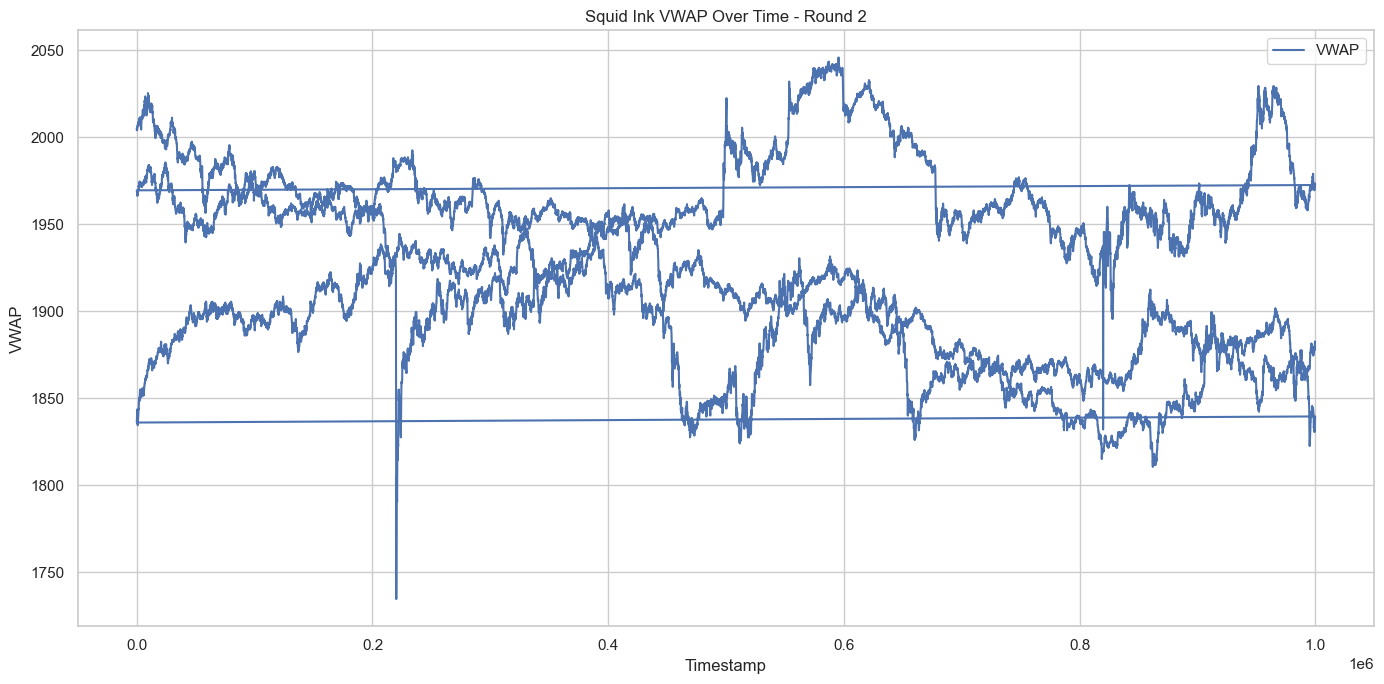

In [8]:
# Plot VWAP over time
plt.figure(figsize=(14, 7))
plt.plot(squid_vwap.index, squid_vwap.values, label='VWAP')
plt.title('Squid Ink VWAP Over Time - Round 2')
plt.xlabel('Timestamp')
plt.ylabel('VWAP')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 5. Calculate and Visualize VWAP Distribution

Let's look at the distribution of VWAP values.

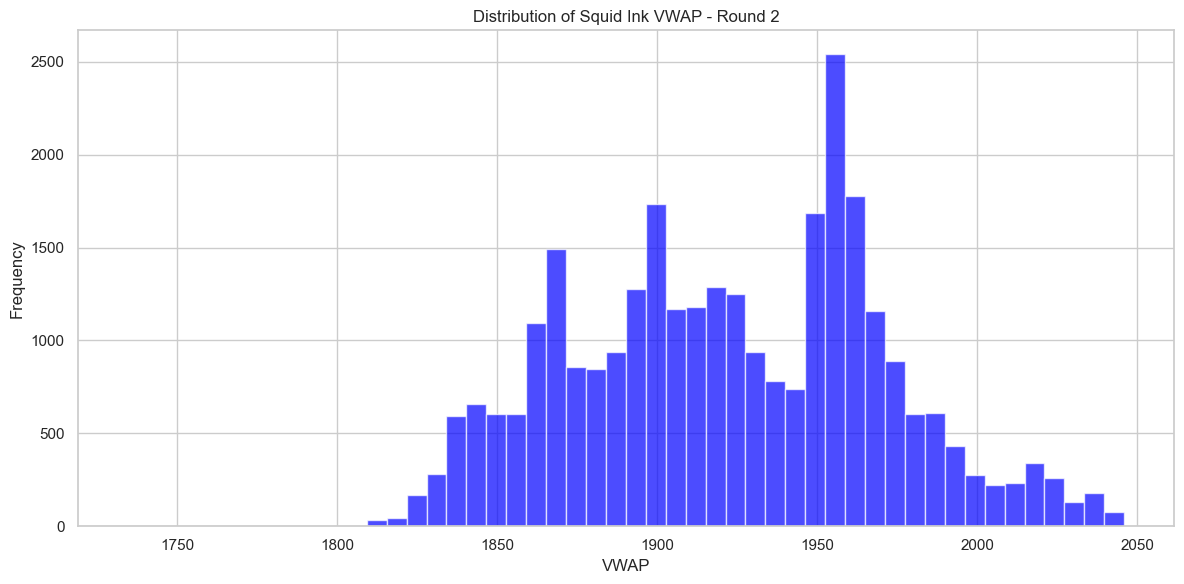

In [9]:
# Plot histogram of VWAP values
plt.figure(figsize=(12, 6))
plt.hist(squid_vwap, bins=50, alpha=0.7, color='blue')
plt.title('Distribution of Squid Ink VWAP - Round 2')
plt.xlabel('VWAP')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

## 6. Calculate VWAP Returns

Let's calculate the returns of the VWAP.

In [10]:
# Calculate returns
vwap_returns = squid_vwap.pct_change().dropna()

# Calculate log returns
log_returns = np.log(squid_vwap).diff().dropna()

# Display basic statistics about the returns
print(f"VWAP returns statistics:")
print(f"Number of data points: {len(vwap_returns)}")
print(f"Min: {vwap_returns.min()}")
print(f"Max: {vwap_returns.max()}")
print(f"Mean: {vwap_returns.mean()}")
print(f"Median: {vwap_returns.median()}")
print(f"Standard deviation: {vwap_returns.std()}")

VWAP returns statistics:
Number of data points: 29999
Min: -0.053963335915311106
Max: 0.03957902397916202
Mean: -1.6639110588064325e-06
Median: 0.0
Standard deviation: 0.0009239363852085086


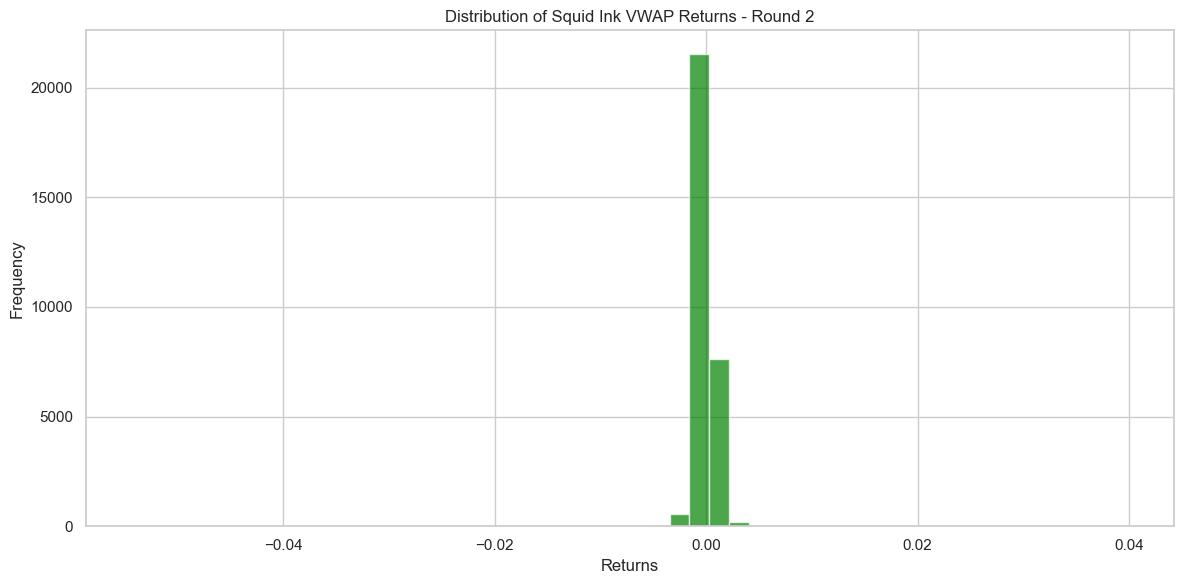

In [11]:
# Plot returns distribution
plt.figure(figsize=(12, 6))
plt.hist(vwap_returns, bins=50, alpha=0.7, color='green')
plt.title('Distribution of Squid Ink VWAP Returns - Round 2')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

## 7. Compare VWAP with Mid Price

Let's compare the VWAP with the mid price.

Mid price is already in the dataframe


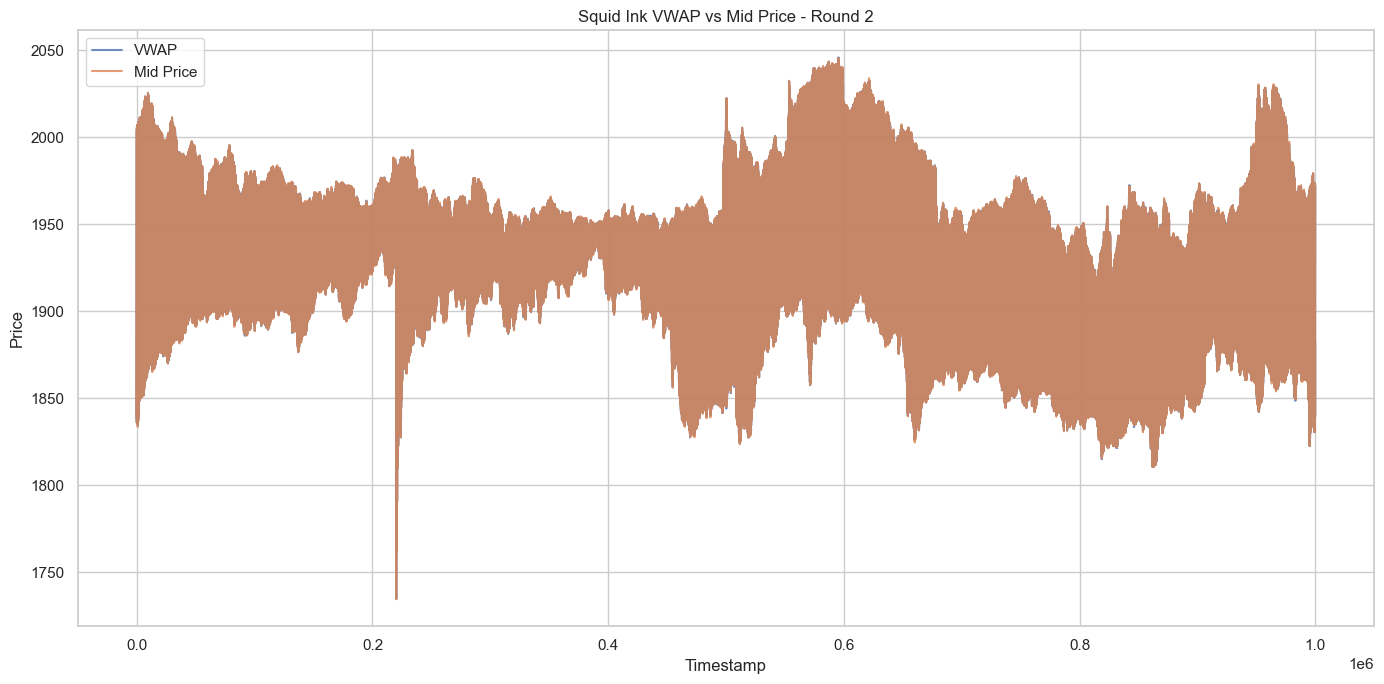

In [12]:
# Calculate mid price if not already in the dataframe
if 'mid_price' not in prices.columns:
    print("Calculating mid price...")
    
    # Make a copy of the dataframe to avoid modifying the original
    prices_copy = prices.copy()
    
    # Calculate mid price
    prices_copy['mid_price'] = (prices_copy['ask_price_1'] + prices_copy['bid_price_1']) / 2
    
    # Set timestamp as index if available and not already set
    if 'timestamp' in prices_copy.columns and prices_copy.index.name != 'timestamp':
        prices_copy.set_index('timestamp', inplace=True)
    
    mid_price = prices_copy['mid_price']
else:
    print("Mid price is already in the dataframe")
    mid_price = prices['mid_price']
    
    # Set timestamp as index if available and not already set
    if 'timestamp' in prices.columns and prices.index.name != 'timestamp':
        mid_price.index = prices['timestamp']

# Ensure both series have the same index
common_index = squid_vwap.index.intersection(mid_price.index)
squid_vwap_aligned = squid_vwap.loc[common_index]
mid_price_aligned = mid_price.loc[common_index]

# Plot VWAP and mid price
plt.figure(figsize=(14, 7))
plt.plot(squid_vwap_aligned.index, squid_vwap_aligned.values, label='VWAP', alpha=0.8)
plt.plot(mid_price_aligned.index, mid_price_aligned.values, label='Mid Price', alpha=0.8)
plt.title('Squid Ink VWAP vs Mid Price - Round 2')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

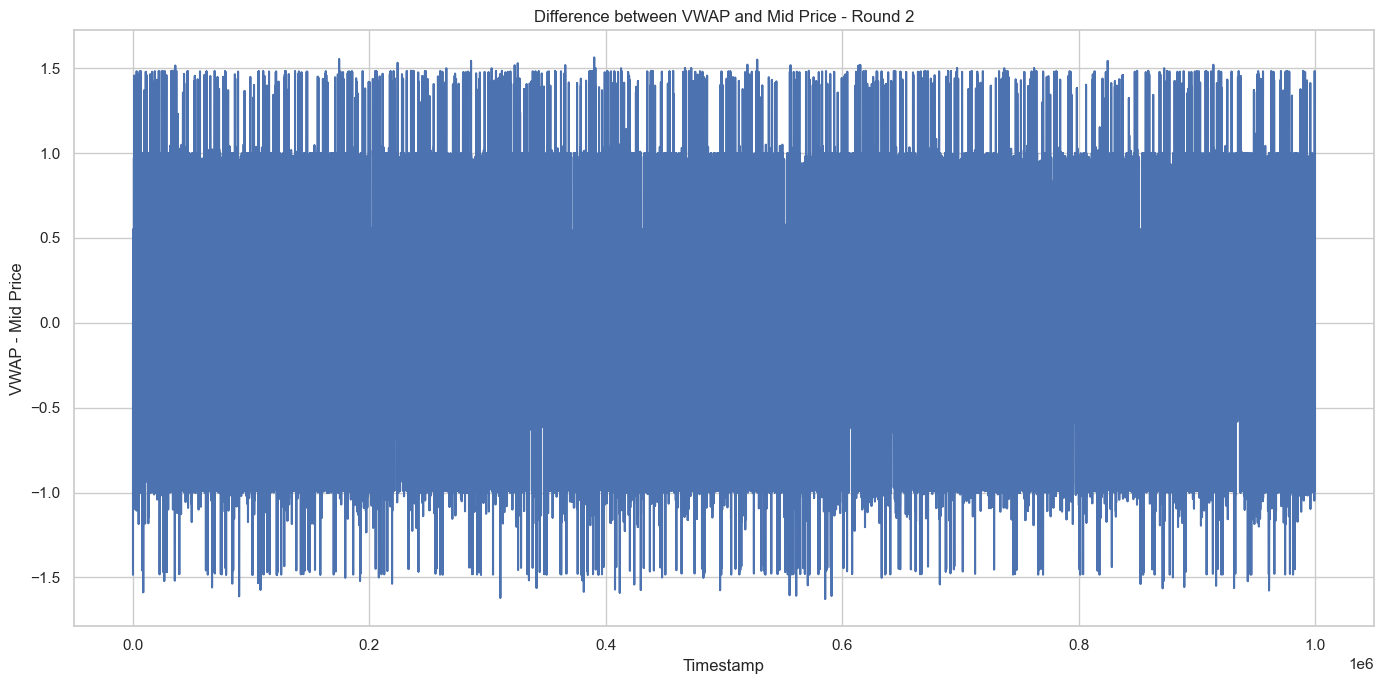

In [13]:
# Calculate the difference between VWAP and mid price
price_diff = squid_vwap_aligned - mid_price_aligned

# Plot the difference
plt.figure(figsize=(14, 7))
plt.plot(price_diff.index, price_diff.values)
plt.title('Difference between VWAP and Mid Price - Round 2')
plt.xlabel('Timestamp')
plt.ylabel('VWAP - Mid Price')
plt.grid(True)
plt.tight_layout()
plt.show()

## 8. Summary

In this notebook, we have:
1. Loaded Squid Ink price data for Round 2
2. Calculated the Volume-Weighted Average Price (VWAP)
3. Visualized the VWAP over time
4. Analyzed the distribution of VWAP values
5. Calculated and analyzed VWAP returns
6. Compared VWAP with mid price

This analysis provides a foundation for further exploration of Squid Ink trading strategies in Round 2.